In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import credentials
import requests

#pulling data API
key =credentials.login['key_isaham']  # extract password

symbol = "FRONTKN"  # which stock to pull
response = requests.get("https://admin.isaham.my/api/chart?stock={}&key={}".format(symbol,key))
data = response.json()

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# makes plots bigger
plt.rcParams["figure.figsize"] = (20,8)

In [2]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

In [3]:
#df= pd.DataFrame.from_dict(data)
df_actual = pd.DataFrame.from_dict(data)

In [4]:
#df= df[['c','d','h','l','o','v']]
df_actual= df_actual[['c','d','h','l','o','v']]

In [5]:
#df['d'] = pd.to_datetime(df['d'], dayfirst= True )
df_actual['d'] = pd.to_datetime(df_actual['d'], dayfirst= True )

In [6]:
#df.set_index('d',inplace=True,drop=True)
df_actual.set_index('d',inplace=True,drop=True)

In [7]:
#df.index.name = None
df_actual.index.name = None

In [8]:
#df.index
df_actual.index

DatetimeIndex(['2008-11-18', '2008-11-19', '2008-11-20', '2008-11-21',
               '2008-11-24', '2008-11-25', '2008-11-26', '2008-11-27',
               '2008-11-28', '2008-12-01',
               ...
               '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
               '2021-03-12', '2021-03-15', '2021-03-16', '2021-03-17',
               '2021-03-18', '2021-03-19'],
              dtype='datetime64[ns]', length=3030, freq=None)

In [9]:
split_date = '2021-03-10'
df= df_actual.loc[df_actual.index < split_date].copy()

In [10]:
df

,c,h,l,o,v
2008-11-18,0.2636,0.2957,0.2564,0.2957,132554.0
2008-11-19,0.2886,0.2886,0.2600,0.2707,81089.0
2008-11-20,0.2636,0.2814,0.2529,0.2814,273370.0
2008-11-21,0.2743,0.2779,0.2636,0.2636,125446.0
2008-11-24,0.2386,0.2707,0.2386,0.2636,36589.0
...,...,...,...,...,...
2021-03-03,5.1200,5.3000,5.0600,5.1700,3444000.0
2021-03-04,5.0600,5.0800,4.9600,5.0300,4704400.0
2021-03-05,4.9900,5.0000,4.8200,4.9400,5413200.0
2021-03-08,4.6700,5.0500,4.6300,5.0400,7378900.0


In [11]:
#Create the "L14" column in the DataFrame
df['L14'] = df['l'].rolling(window=14).min()

In [12]:
#Create the "H14" column in the DataFrame
df['H14'] = df['h'].rolling(window=14).max()

In [13]:
#Create the "%K" column in the DataFrame
df['%K'] = 100*((df['c'] - df['L14']) / (df['H14'] - df['L14']) )

In [14]:
#Create the "%D" column in the DataFrame
df['%D'] = df['%K'].rolling(window=3).mean()

In [15]:
df.head(5)

,c,h,l,o,v,L14,H14,%K,%D
2008-11-18,0.2636,0.2957,0.2564,0.2957,132554.0,NaN,NaN,NaN,NaN
2008-11-19,0.2886,0.2886,0.2600,0.2707,81089.0,NaN,NaN,NaN,NaN
2008-11-20,0.2636,0.2814,0.2529,0.2814,273370.0,NaN,NaN,NaN,NaN
2008-11-21,0.2743,0.2779,0.2636,0.2636,125446.0,NaN,NaN,NaN,NaN
2008-11-24,0.2386,0.2707,0.2386,0.2636,36589.0,NaN,NaN,NaN,NaN


In [16]:
df.tail(5)

,c,h,l,o,v,L14,H14,%K,%D
2021-03-03,5.12,5.30,5.06,5.17,3444000.0,4.69,5.95,34.126984,35.714286
2021-03-04,5.06,5.08,4.96,5.03,4704400.0,4.69,5.95,29.365079,34.656085
2021-03-05,4.99,5.00,4.82,4.94,5413200.0,4.69,5.95,23.809524,29.100529
2021-03-08,4.67,5.05,4.63,5.04,7378900.0,4.63,5.95,3.030303,18.734969
2021-03-09,4.60,4.83,4.40,4.59,14669700.0,4.40,5.95,12.903226,13.247684


Text(0.5, 1.0, 'Oscillator')

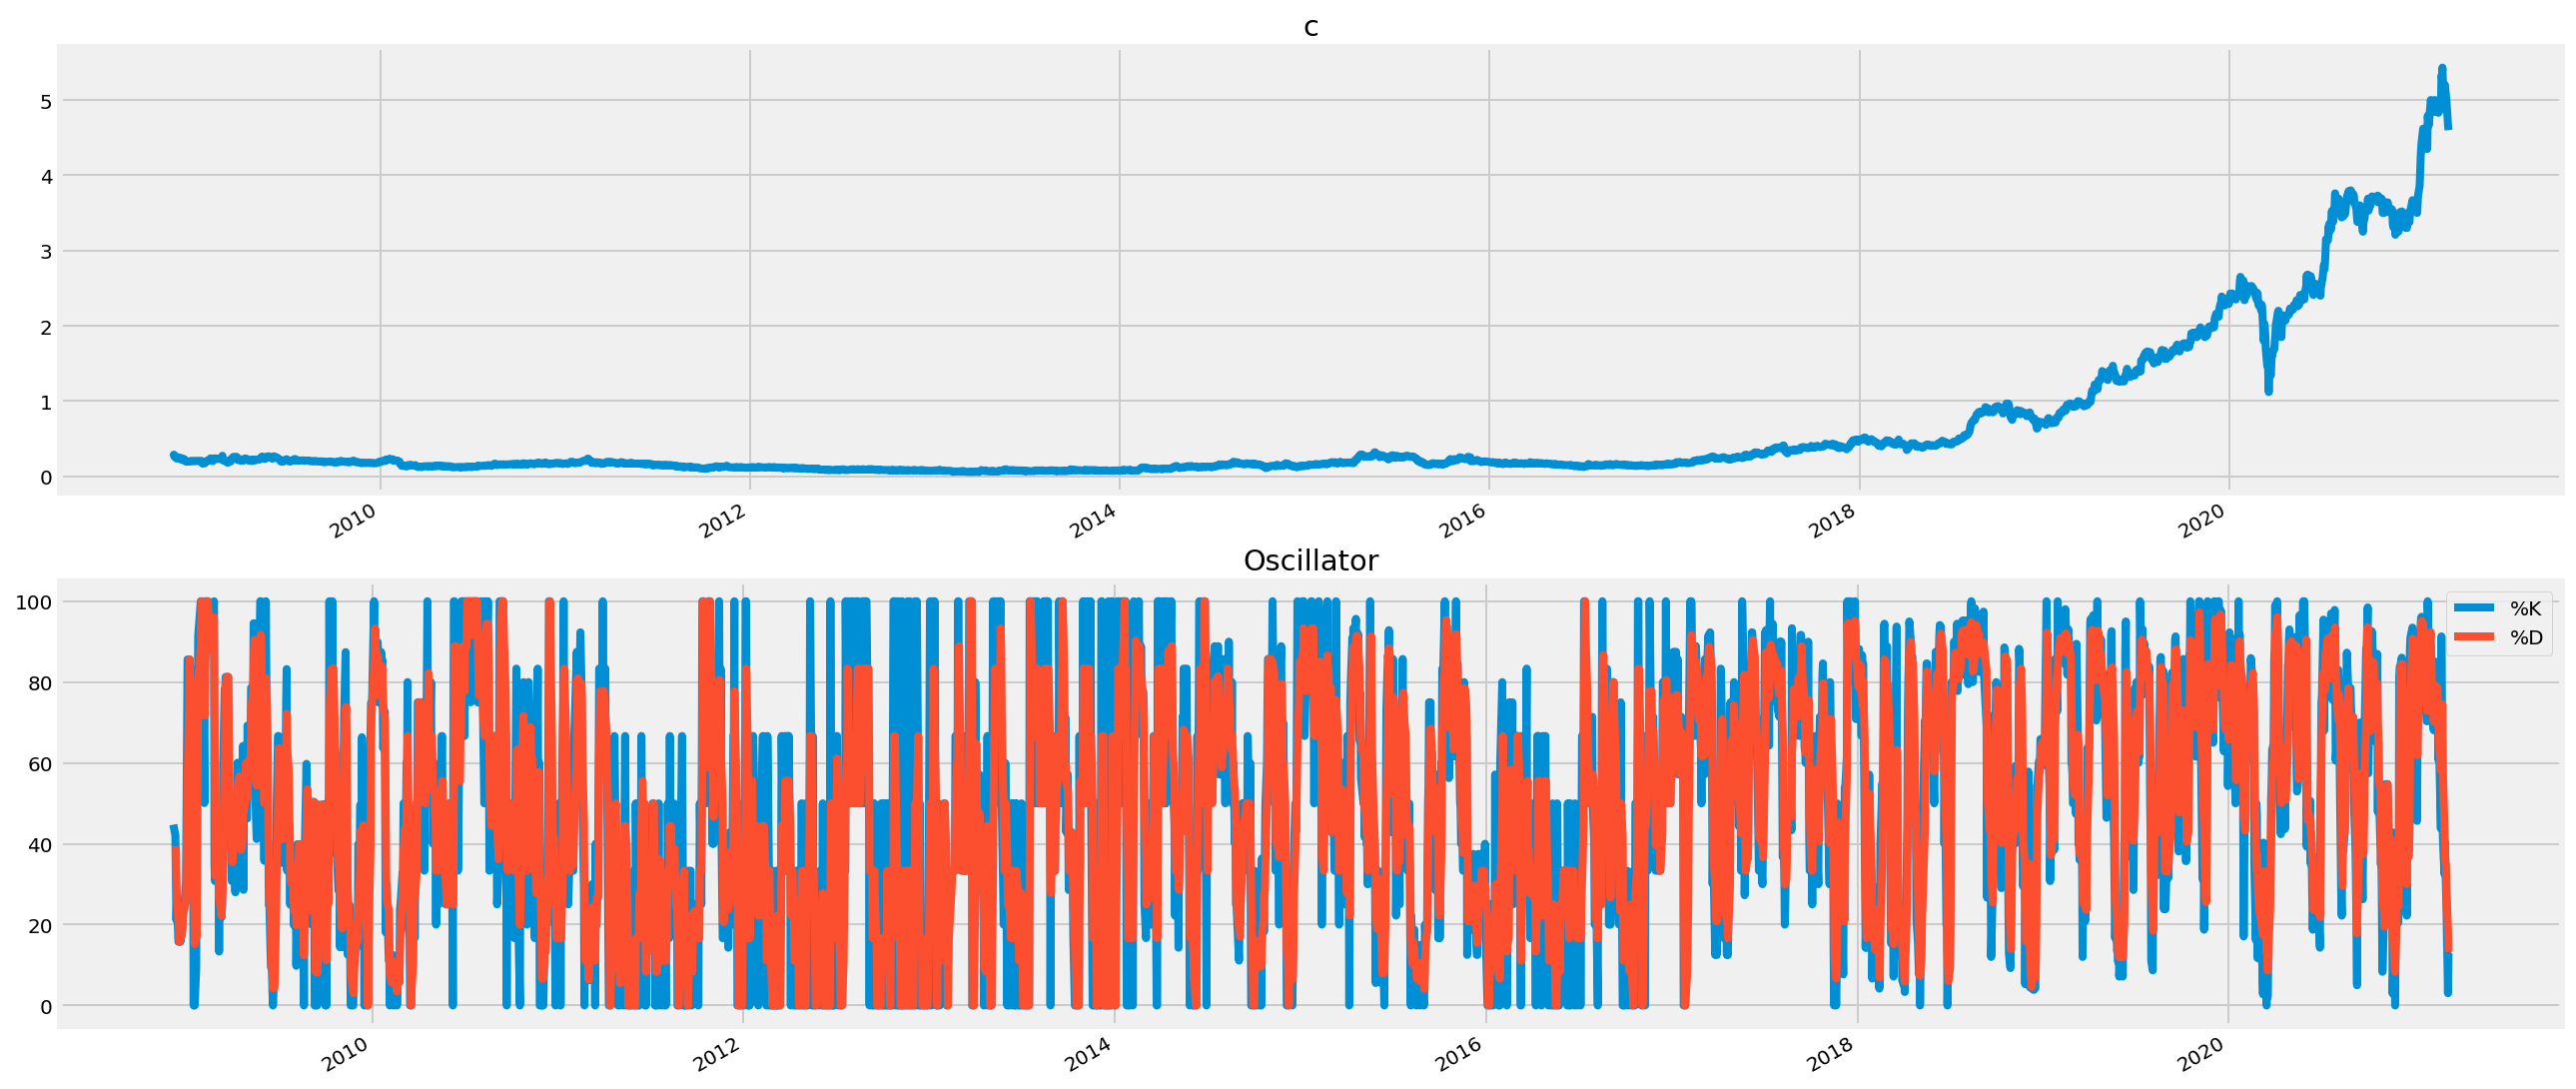

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
df['c'].plot(ax=axes[0]); axes[0].set_title('c')
df[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator')

In [18]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
df['Sell OB'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 

In [19]:
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
df['Buy OS'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 20) 

In [20]:
df['Strategy'] = np.nan  
df.loc[df['Buy OS'],'Strategy'] = 1  
df.loc[df['Sell OB'],'Strategy'] = 0 

In [21]:
df

,c,h,l,o,v,L14,H14,%K,%D,Sell OB,Buy OS,Strategy
2008-11-18,0.2636,0.2957,0.2564,0.2957,132554.0,NaN,NaN,NaN,NaN,False,False,NaN
2008-11-19,0.2886,0.2886,0.2600,0.2707,81089.0,NaN,NaN,NaN,NaN,False,False,NaN
2008-11-20,0.2636,0.2814,0.2529,0.2814,273370.0,NaN,NaN,NaN,NaN,False,False,NaN
2008-11-21,0.2743,0.2779,0.2636,0.2636,125446.0,NaN,NaN,NaN,NaN,False,False,NaN
2008-11-24,0.2386,0.2707,0.2386,0.2636,36589.0,NaN,NaN,NaN,NaN,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03,5.1200,5.3000,5.0600,5.1700,3444000.0,4.69,5.95,34.126984,35.714286,False,False,NaN
2021-03-04,5.0600,5.0800,4.9600,5.0300,4704400.0,4.69,5.95,29.365079,34.656085,False,False,NaN
2021-03-05,4.9900,5.0000,4.8200,4.9400,5413200.0,4.69,5.95,23.809524,29.100529,False,False,NaN
2021-03-08,4.6700,5.0500,4.6300,5.0400,7378900.0,4.63,5.95,3.030303,18.734969,False,False,NaN


In [22]:
overbought =df['Sell OB']

In [23]:
oversold =df['Buy OS']

In [24]:
date_os=list(oversold[oversold == True].index)

In [25]:
date_ob=list(overbought[overbought == True].index)

In [26]:
# transaction recording
buy = []
sell = []
sdate = []
bdate = []
wr = []
pct = []


for n,i in enumerate(date_os):
    print(n,"Buy:", i, "Price:", df['c'].loc[i])
    buy.append(df['c'].loc[i])
    bdate.append(i)
    r=[]
    #print("before", len(r))
    for m,k in enumerate(date_ob):
        
        if k>i:
            r.append(m)
            #print('after',len(r))
            if len(r) ==1:
                print(m,"Sell :", k, "Price:",df['c'].loc[k])
                print("Percentage change:",(((df['c'].loc[k]/df['c'].loc[i])-1)*100) )
                sell.append(df['c'].loc[k])
                sdate.append(k)
                pct_change=((df['c'].loc[k]/df['c'].loc[i])-1)*100
                pct.append(((df['c'].loc[k]/df['c'].loc[i])-1)*100)
                wr =pct_change>0
                #print(wr)
                #print(len(wr[wr==True])+n)
                                
                if pct_change >0:
                    print("1")
                    #print(len(wr[wr==True])+n)
                    #wr.append(1)
                    
                else:
                    print('0')
                    #print(len(wr[wr==True])-n)
                    #wr.append(0)
                    
            elif len(r)>1:
                pass
            
        
    print('........')
print('Number of trade:',len(date_os))

dct = {
    "Buy_Date": bdate,
    "Buy": buy,
    "Sell": sell,
    "Sell_Date": sdate,
    #"W_rate": wr,
    "Pct_change": pct
    
}

trans = pd.DataFrame(dct)
#print(len(wr[wr==True]))

0 Buy: 2008-12-18 00:00:00 Price: 0.1993
0 Sell : 2009-02-03 00:00:00 Price: 0.2136
Percentage change: 7.1751128951329735
1
........
1 Buy: 2008-12-22 00:00:00 Price: 0.1993
0 Sell : 2009-02-03 00:00:00 Price: 0.2136
Percentage change: 7.1751128951329735
1
........
2 Buy: 2009-01-20 00:00:00 Price: 0.185
0 Sell : 2009-02-03 00:00:00 Price: 0.2136
Percentage change: 15.459459459459456
1
........
3 Buy: 2009-06-22 00:00:00 Price: 0.1957
4 Sell : 2009-10-15 00:00:00 Price: 0.2029
Percentage change: 3.6791006642820534
1
........
4 Buy: 2009-08-05 00:00:00 Price: 0.21
4 Sell : 2009-10-15 00:00:00 Price: 0.2029
Percentage change: -3.3809523809523734
0
........
5 Buy: 2009-08-18 00:00:00 Price: 0.2029
4 Sell : 2009-10-15 00:00:00 Price: 0.2029
Percentage change: 0.0
0
........
6 Buy: 2009-08-20 00:00:00 Price: 0.2029
4 Sell : 2009-10-15 00:00:00 Price: 0.2029
Percentage change: 0.0
0
........
7 Buy: 2009-09-15 00:00:00 Price: 0.1921
4 Sell : 2009-10-15 00:00:00 Price: 0.2029
Percentage change

92 Sell : 2018-02-26 00:00:00 Price: 0.455
Percentage change: 0.0
0
........
84 Buy: 2018-02-14 00:00:00 Price: 0.41
92 Sell : 2018-02-26 00:00:00 Price: 0.455
Percentage change: 10.97560975609757
1
........
85 Buy: 2018-03-12 00:00:00 Price: 0.435
93 Sell : 2018-04-17 00:00:00 Price: 0.435
Percentage change: 0.0
0
........
86 Buy: 2018-03-14 00:00:00 Price: 0.43
93 Sell : 2018-04-17 00:00:00 Price: 0.435
Percentage change: 1.1627906976744207
1
........
87 Buy: 2018-04-03 00:00:00 Price: 0.4
93 Sell : 2018-04-17 00:00:00 Price: 0.435
Percentage change: 8.749999999999991
1
........
88 Buy: 2018-04-05 00:00:00 Price: 0.38
93 Sell : 2018-04-17 00:00:00 Price: 0.435
Percentage change: 14.473684210526304
1
........
89 Buy: 2018-05-03 00:00:00 Price: 0.395
95 Sell : 2018-06-06 00:00:00 Price: 0.435
Percentage change: 10.126582278481
1
........
90 Buy: 2018-05-07 00:00:00 Price: 0.385
95 Sell : 2018-06-06 00:00:00 Price: 0.435
Percentage change: 12.987012987012992
1
........
91 Buy: 2018-06-2

In [27]:
trans

,Buy_Date,Buy,Sell,Sell_Date,Pct_change
0,2008-12-18,0.1993,0.2136,2009-02-03,7.175113
1,2008-12-22,0.1993,0.2136,2009-02-03,7.175113
2,2009-01-20,0.1850,0.2136,2009-02-03,15.459459
3,2009-06-22,0.1957,0.2029,2009-10-15,3.679101
4,2009-08-05,0.2100,0.2029,2009-10-15,-3.380952
...,...,...,...,...,...
98,2020-03-17,1.6100,2.0500,2020-04-03,27.329193
99,2020-03-20,1.4500,2.0500,2020-04-03,41.379310
100,2020-11-03,3.5300,3.5100,2020-12-08,-0.566572
101,2020-11-23,3.3500,3.5100,2020-12-08,4.776119


In [28]:
wr = []
for i in range(len(trans)):
    if trans["Pct_change"][i] > 0:
        wr.append(1)
    else:
        wr.append(0)
trans["wr"] = pd.Series(wr)

In [29]:
trans

,Buy_Date,Buy,Sell,Sell_Date,Pct_change,wr
0,2008-12-18,0.1993,0.2136,2009-02-03,7.175113,1
1,2008-12-22,0.1993,0.2136,2009-02-03,7.175113,1
2,2009-01-20,0.1850,0.2136,2009-02-03,15.459459,1
3,2009-06-22,0.1957,0.2029,2009-10-15,3.679101,1
4,2009-08-05,0.2100,0.2029,2009-10-15,-3.380952,0
...,...,...,...,...,...,...
98,2020-03-17,1.6100,2.0500,2020-04-03,27.329193,1
99,2020-03-20,1.4500,2.0500,2020-04-03,41.379310,1
100,2020-11-03,3.5300,3.5100,2020-12-08,-0.566572,0
101,2020-11-23,3.3500,3.5100,2020-12-08,4.776119,1


In [30]:
trans.head(20)

,Buy_Date,Buy,Sell,Sell_Date,Pct_change,wr
0,2008-12-18,0.1993,0.2136,2009-02-03,7.175113,1
1,2008-12-22,0.1993,0.2136,2009-02-03,7.175113,1
2,2009-01-20,0.1850,0.2136,2009-02-03,15.459459,1
3,2009-06-22,0.1957,0.2029,2009-10-15,3.679101,1
4,2009-08-05,0.2100,0.2029,2009-10-15,-3.380952,0
5,2009-08-18,0.2029,0.2029,2009-10-15,0.000000,0
6,2009-08-20,0.2029,0.2029,2009-10-15,0.000000,0
7,2009-09-15,0.1921,0.2029,2009-10-15,5.622072,1
8,2009-11-20,0.1850,0.2064,2010-01-06,11.567568,1
9,2009-11-25,0.1779,0.2064,2010-01-06,16.020236,1


In [31]:
wrate = round(len(trans[trans["wr"]==1])/len(trans["wr"])*100, 4)
print("Winning rate at {}% for {} trades.".format(wrate, len(trans["wr"])))
risk = 100-wrate
print("While, using this strategy, we are exposed to {}% of lossing risk for {} trades.".format(risk, len(trans["wr"])))

Winning rate at 48.5437% for 103 trades.
While, using this strategy, we are exposed to 51.4563% of lossing risk for 103 trades.
